In [41]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import itertools

In [3]:
filename = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(filename)
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [4]:
# Create Dataframe with relevant columns
collisions = df[['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE','PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'INATTENTIONIND', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'UNDERINFL','SPEEDING','HITPARKEDCAR']]
collisions.shape

(194673, 15)

## Data Cleaning

In [5]:
# Removing Rows where Feature values are unknowns
collisions = collisions[collisions['JUNCTIONTYPE'] != "Unknown"]
collisions = collisions[collisions['WEATHER'] != "Unknown"]
collisions = collisions[collisions['ROADCOND'] != "Unknown"]
collisions = collisions[collisions['LIGHTCOND'] != "Unknown"]

# Speeding NaN with No! 
collisions['SPEEDING'] = collisions['SPEEDING'].fillna('N')
collisions['INATTENTIONIND'] = collisions['INATTENTIONIND'].fillna('N')

# Drop NaN
collisions.dropna()
collisions = collisions.reset_index(drop=True)

In [6]:
collisions.shape

(175763, 15)

In [7]:
# Convert Y and N to 1 and 0 (numerical values)
collisions['INATTENTIONIND'].replace('N',0, inplace=True)
collisions['INATTENTIONIND'].replace('Y',0, inplace=True)

collisions['SPEEDING'].replace('N',0, inplace=True)
collisions['SPEEDING'].replace('Y',1, inplace=True)


collisions['HITPARKEDCAR'].replace('N',0, inplace=True)
collisions['HITPARKEDCAR'].replace('Y',1, inplace=True)

collisions['UNDERINFL'].replace('N',0, inplace=True)
collisions['UNDERINFL'].replace('Y',1, inplace=True)

In [8]:
# Subframe - with relevant Features for Model.
collisions = collisions[['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE','WEATHER', 'LIGHTCOND','ROADCOND', 'UNDERINFL','SPEEDING','INATTENTIONIND', 'HITPARKEDCAR']]
collisions.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,WEATHER,LIGHTCOND,ROADCOND,UNDERINFL,SPEEDING,INATTENTIONIND,HITPARKEDCAR
0,2,Intersection,Angles,Overcast,Daylight,Wet,0,0,0,0
1,1,Block,Sideswipe,Raining,Dark - Street Lights On,Wet,0,0,0,0
2,1,Block,Parked Car,Overcast,Daylight,Dry,0,0,0,0
3,1,Block,Other,Clear,Daylight,Dry,0,0,0,0
4,2,Intersection,Angles,Raining,Daylight,Wet,0,0,0,0


In [9]:
# Categorical Variable to Numeric values.
collisions['ADDRTYPE'].value_counts()
collisions = collisions[pd.notnull(collisions['ADDRTYPE'])]
collisions = collisions.reset_index(drop=True)

addrtype = preprocessing.LabelEncoder()
addrtype.fit(['Block','Intersection','Alley'])
collisions['ADDRTYPE'] = addrtype.transform(collisions['ADDRTYPE'])

collisions.shape

(174926, 10)

In [10]:
collisions['COLLISIONTYPE'].value_counts()
collisions = collisions[pd.notnull(collisions['COLLISIONTYPE'])]
collisions = collisions.reset_index(drop=True)

# Remove "Other"
collisions = collisions[collisions.COLLISIONTYPE != 'Other']

colltype = preprocessing.LabelEncoder()
colltype.fit(['Angles','Parked Car','Rear Ended','Rear Ended','Sideswipe','Left Turn','Pedestrian','Cycles','Right Turn','Head On'])
collisions['COLLISIONTYPE'] = colltype.transform(collisions['COLLISIONTYPE'])

collisions.shape

(147595, 10)

In [11]:
collisions['WEATHER'].value_counts()

collisions = collisions[pd.notnull(collisions['WEATHER'])]
collisions = collisions.reset_index(drop=True)

# Remove "Other"
collisions = collisions[collisions.WEATHER != 'Other']

weathertype = preprocessing.LabelEncoder()
weathertype.fit(['Clear','Raining', 'Overcast', 'Snowing', 'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain','Blowing Sand/Dirt','Severe Crosswind','Partly Cloudy'])
collisions['WEATHER'] = weathertype.transform(collisions['WEATHER'])

collisions.shape

(147253, 10)

In [12]:
collisions['LIGHTCOND'].value_counts()

collisions = collisions[pd.notnull(collisions['LIGHTCOND'])]
collisions = collisions.reset_index(drop=True)

collisions = collisions[collisions.LIGHTCOND != 'Other']
collisions['LIGHTCOND'] = collisions['LIGHTCOND'].replace('Dark - Street Lights On', 'Dark')
collisions['LIGHTCOND'] = collisions['LIGHTCOND'].replace('Dark - No Street Lights', 'Dark')
collisions['LIGHTCOND'] = collisions['LIGHTCOND'].replace('Dark - Street Lights Off','Dark')
collisions['LIGHTCOND'] = collisions['LIGHTCOND'].replace('Dark - Unknown Lighting', 'Dark')

light_type = preprocessing.LabelEncoder()
light_type.fit(['Daylight','Dark', 'Dusk', 'Dawn'])
collisions['LIGHTCOND'] = light_type.transform(collisions['LIGHTCOND'])

collisions.shape

(146967, 10)

In [13]:
collisions['ROADCOND'].value_counts()

collisions = collisions[pd.notnull(collisions['ROADCOND'])]
collisions = collisions.reset_index(drop=True)

collisions = collisions[collisions.ROADCOND != 'Other']


roadcond = preprocessing.LabelEncoder()
roadcond.fit(['Dry','Wet','Ice','Snow/Slush','Standing Water','Sand/Mud/Dirt','Oil'])
collisions['ROADCOND'] = roadcond.transform(collisions['ROADCOND'])

collisions.shape

(146880, 10)

In [14]:
collisions.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,WEATHER,LIGHTCOND,ROADCOND,UNDERINFL,SPEEDING,INATTENTIONIND,HITPARKEDCAR
0,2,2,0,3,2,6,0,0,0,0
1,1,1,8,5,0,6,0,0,0,0
2,1,1,4,3,2,0,0,0,0,0
3,2,2,0,5,2,6,0,0,0,0
4,1,2,0,1,2,0,0,0,0,0


In [15]:
X = collisions[['ADDRTYPE','COLLISIONTYPE','WEATHER','LIGHTCOND','ROADCOND','UNDERINFL','SPEEDING','INATTENTIONIND','HITPARKEDCAR']].values
X[0:5]

array([[2, 0, 3, 2, 6, 0, 0, 0, 0],
       [1, 8, 5, 0, 6, '0', 0, 0, 0],
       [1, 4, 3, 2, 0, '0', 0, 0, 0],
       [2, 0, 5, 2, 6, '0', 0, 0, 0],
       [2, 0, 1, 2, 0, 0, 0, 0, 0]], dtype=object)

In [16]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.23775641, -1.45144996,  0.55758625,  0.56591988,  1.65791983,
        -0.21328644, -0.1956852 ,  0.        , -0.18213444],
       [-0.79200491,  1.54405507,  1.7880567 , -1.58759157,  1.65791983,
        -0.21328644, -0.1956852 ,  0.        , -0.18213444],
       [-0.79200491,  0.04630256,  0.55758625,  0.56591988, -0.60860348,
        -0.21328644, -0.1956852 ,  0.        , -0.18213444],
       [ 1.23775641, -1.45144996,  1.7880567 ,  0.56591988,  1.65791983,
        -0.21328644, -0.1956852 ,  0.        , -0.18213444],
       [ 1.23775641, -1.45144996, -0.67288421,  0.56591988, -0.60860348,
        -0.21328644, -0.1956852 ,  0.        , -0.18213444]])

In [17]:
y = collisions['SEVERITYCODE']
y[0:5]

0    2
1    1
2    1
3    2
4    1
Name: SEVERITYCODE, dtype: int64

In [18]:
# 20 % for testing and 80% training data.
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)

In [19]:
print("X Train Set: ", X_trainset.shape)
print("Y Train Set: ",  y_trainset.shape)
print("X Test Set: ", X_testset.shape)
print("Y Test Set: ",  y_testset.shape)

X Train Set:  (117504, 9)
Y Train Set:  (117504,)
X Test Set:  (29376, 9)
Y Test Set:  (29376,)


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Decision Tree

In [21]:
SeverityTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
SeverityTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
SeverityTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
predTree = SeverityTree.predict(X_testset)

In [24]:
predTree_prob = SeverityTree.predict_proba(X_testset)

In [25]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))
print("DecisionTrees's Jaccard Index: ", jaccard_similarity_score(y_testset, predTree))
print("DecisionTrees's F1 Score: ", f1_score(y_testset, predTree,average='weighted'))
print("Decision Tree Log Loss: ", log_loss(y_testset, predTree_prob))

DecisionTrees's Accuracy:  0.7043164488017429
DecisionTrees's Jaccard Index:  0.7043164488017429
DecisionTrees's F1 Score:  0.6387477397745317
Decision Tree Log Loss:  0.5359590598294064


In [26]:
print (classification_report(y_testset, predTree))


              precision    recall  f1-score   support

           1       0.70      0.97      0.81     19422
           2       0.76      0.19      0.30      9954

   micro avg       0.70      0.70      0.70     29376
   macro avg       0.73      0.58      0.56     29376
weighted avg       0.72      0.70      0.64     29376



Confusion matrix, without normalization
[[18833   589]
 [ 8097  1857]]


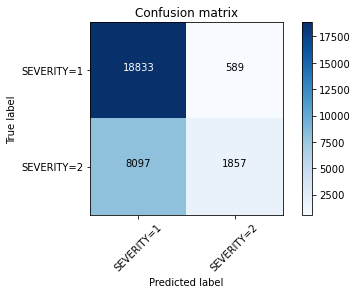

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, predTree, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITY=1','SEVERITY=2'],normalize= False,  title='Confusion matrix')

## Logistic Regression

In [28]:
LR = LogisticRegression(C=1, solver='liblinear').fit(X_trainset,y_trainset)
LR

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
y = LR.predict(X_testset)
y

array([1, 1, 1, ..., 1, 1, 1])

In [30]:
y_prob = LR.predict_proba(X_testset)
y_prob

array([[0.68, 0.32],
       [0.71, 0.29],
       [0.56, 0.44],
       ...,
       [0.75, 0.25],
       [0.53, 0.47],
       [0.64, 0.36]])

In [31]:
print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_testset, y))
print("Logistic Regression Jaccard Similarity: ", jaccard_similarity_score(y_testset, y))
print("Logistic Regression F1 Score: ", f1_score(y_testset, y,average='weighted'))
print("Logistic Regression Log Loss: ", log_loss(y_testset, y_prob))

Logistic Regression Accuracy:  0.6621732026143791
Logistic Regression Jaccard Similarity:  0.6621732026143791
Logistic Regression F1 Score:  0.54660818963074
Logistic Regression Log Loss:  0.61656822829557


In [32]:
print (classification_report(y_testset, y))


              precision    recall  f1-score   support

           1       0.67      0.98      0.79     19422
           2       0.52      0.03      0.06      9954

   micro avg       0.66      0.66      0.66     29376
   macro avg       0.59      0.51      0.43     29376
weighted avg       0.62      0.66      0.55     29376



Confusion matrix, without normalization
[[19112   310]
 [ 9614   340]]


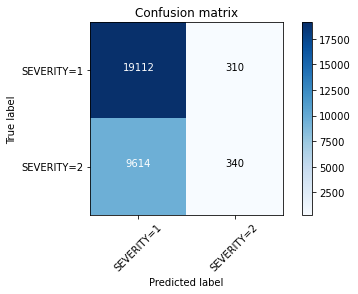

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, y, labels=[1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITY=1','SEVERITY=2'],normalize= False,  title='Confusion matrix')

## Support Vector Machine (SVM)

In [34]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_trainset, y_trainset) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
y = clf.predict(X_testset)
y [0:5]

array([1, 1, 2, 1, 1])

In [37]:
print("SVM Accuracy: ", metrics.accuracy_score(y_testset, y))
print("SVM Jaccard Similarity: ", jaccard_similarity_score(y_testset, y))
print("SVM F1 Score: ", f1_score(y_testset, y,average='weighted'))

SVM Accuracy:  0.6659517973856209
SVM Jaccard Similarity:  0.6659517973856209
SVM F1 Score:  0.6129765109246283


In [38]:
print (classification_report(y_testset, y))

              precision    recall  f1-score   support

           1       0.69      0.91      0.78     19422
           2       0.52      0.19      0.28      9954

   micro avg       0.67      0.67      0.67     29376
   macro avg       0.60      0.55      0.53     29376
weighted avg       0.63      0.67      0.61     29376



Confusion matrix, without normalization
[[17630  1792]
 [ 8021  1933]]


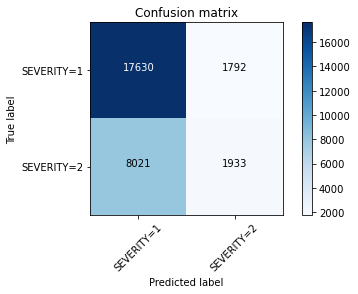

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, y, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITY=1','SEVERITY=2'],normalize= False,  title='Confusion matrix')

### K  Nearest Neighbot

In [43]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_trainset,y_trainset)
    y     =neigh.predict(X_testset)
    mean_acc[n-1] = metrics.accuracy_score(y_testset, y)

    
    std_acc[n-1]=np.std(y==y_testset)/np.sqrt(y.shape[0])

mean_acc

array([0.64, 0.67, 0.65, 0.68, 0.67, 0.7 , 0.68, 0.69, 0.69])

In [44]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.6972698801742919 with k= 6


In [45]:
neigh = KNeighborsClassifier(n_neighbors = 6).fit(X_trainset,y_trainset)
y     = neigh.predict(X_testset)

In [47]:
print("KNN Accuracy: ", metrics.accuracy_score(y_testset, y))
print("KNN Jaccard Similarity: ", jaccard_similarity_score(y_testset, y))
print("KNN F1 Score: ", f1_score(y_testset, y,average='weighted'))

KNN Accuracy:  0.6972698801742919
KNN Jaccard Similarity:  0.6972698801742919
KNN F1 Score:  0.678316002547278


In [48]:
print (classification_report(y_testset, y))

              precision    recall  f1-score   support

           1       0.73      0.86      0.79     19422
           2       0.58      0.38      0.46      9954

   micro avg       0.70      0.70      0.70     29376
   macro avg       0.66      0.62      0.63     29376
weighted avg       0.68      0.70      0.68     29376



Confusion matrix, without normalization
[[16673  2749]
 [ 6144  3810]]


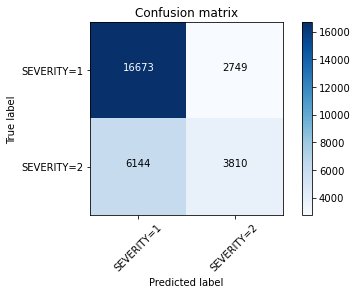

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, y, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITY=1','SEVERITY=2'],normalize= False,  title='Confusion matrix')